In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import config
import process_data

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

# apply mask: only keep vox with mask = 1

**Single subject Data 100206**

In [3]:
scan = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [4]:
mask = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [5]:
scan_dimension = scan.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [6]:
print(x, y, z, b)

print('The shape of scan: ')
print(scan.shape)
print('The shape of mask: ')
print(mask.shape)

print(type(scan), type(mask))

145 174 145 288
The shape of scan: 
(145, 174, 145, 288)
The shape of mask: 
(145, 174, 145)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
scan_long = np.reshape(scan, (x*y*z, b))

In [8]:
mask_long = np.reshape(mask, (x*y*z, 1))

In [9]:
scan_long_no_background = process_data.trim_background(scan_long, mask_long)

In [10]:
scan_long_no_background.shape

(936256, 288)

In [11]:
scan_long_no_bg_cp = scan_long_no_background

In [15]:
# Ignore all strange data

def find_rows_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

Sb_beginning_0 = find_rows_beginning_with_zero(scan_long_no_background)
scan_long_no_bg = np.delete(scan_long_no_background, Sb_beginning_0, 0)

print(scan_long_no_bg.shape)
print(scan_long_no_background.shape)

In [12]:
bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [16]:
S0 = process_data.get_S0(scan_long_no_background, bval_list)

In [17]:
print(S0.shape)

(936256, 1)


In [18]:
error_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]

In [20]:
len(error_voxels)

171

In [21]:
scan_long_no_bg = np.delete(scan_long_no_background, error_voxels, 0)
S0_ = np.delete(S0, error_voxels, 0)

In [22]:
print(scan_long_no_bg.shape)
print(S0_.shape)

(936085, 288)
(936085, 1)


In [23]:
np.save('S0_2.npy',S0_)
# S0 = np.load('S0_1.npy')

In [24]:
normalized_scan_long_no_background = process_data.normalize_scan(scan_long_no_bg, S0_)

In [28]:
np.save('normalized_scan_long_2.npy', normalized_scan_long_no_background)
# normalized_scan_long_no_background = np.load('normalized_scan_long5.npy')

In [27]:
np.argwhere(normalized_scan_long_no_background>10)

array([[1.30231222, 0.79474696, 0.5139521 , ..., 0.6643841 , 0.56590588,
        0.31567214],
       [1.11819184, 0.4604651 , 0.57350542, ..., 0.44744371, 0.67474822,
        0.35966567],
       [1.02967767, 0.47128865, 0.34843168, ..., 0.36720369, 0.55323395,
        0.29989738],
       ...,
       [0.93215207, 0.33621187, 0.17415006, ..., 0.26950286, 0.17028434,
        0.28959991],
       [0.94993517, 0.55332968, 0.43955593, ..., 0.30752529, 0.37428291,
        0.17693152],
       [0.99949699, 0.14943101, 0.15482027, ..., 0.2864064 , 0.37132859,
        0.30503306]])

## Neural Network Training

Let's create the neural network class and instantiate it.

In [29]:
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        # print('x')
        # print(X.shape)
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        # print(params.shape)
        # print(params)
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [30]:
net = Net(bval_list)
print(net)

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)


In [31]:
# Network
b_values = torch.FloatTensor(bval_list)
net = Net(b_values)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)  

In [32]:
print(b_values.shape)
print(b_values.type)

torch.Size([288])
<built-in method type of Tensor object at 0x17a067e70>


Create batch queues.

In [33]:
batch_size = 128
num_batches = len(normalized_scan_long_no_background) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

Train, this might take a few minutes.

In [34]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

# Train
counter = 0
for epoch in range(1000): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # print('Running_loss: ', running_loss)
        # print('X_batch: ')
        # print(X_batch.shape)
        # print(X_batch)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        # print('X_pred: ')
        # print(X_pred.shape)
        # print(X_pred)
        if i == 8 and counter == 10:
            print(X_pred)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        # print('loss: ', loss.item())
        running_loss += loss.item()

    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/len(trainloader)))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
# Restore best model
net.load_state_dict(final_model)
#        DP            Dt           Fp

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:30<00:00, 241.10it/s]


Loss: 5253.041341878474
Average Loss: 0.7183155123586044
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:30<00:00, 240.12it/s]


Loss: 5238.899069957435
Average Loss: 0.7163816586841837
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:33<00:00, 218.51it/s]


Loss: 5236.991417609155
Average Loss: 0.7161208009858
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 229.57it/s]


Loss: 5204.100434135646
Average Loss: 0.7116231962444477
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:32<00:00, 225.33it/s]


Loss: 5168.3888914734125
Average Loss: 0.7067399003792442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:30<00:00, 236.30it/s]


Loss: 4799.517758504488
Average Loss: 0.656299433680362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 233.46it/s]


Loss: 4728.531504360959
Average Loss: 0.6465925754630054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:32<00:00, 227.62it/s]


Loss: 4702.129258958623
Average Loss: 0.6429822588484374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:32<00:00, 224.97it/s]


Loss: 4714.911388373002
Average Loss: 0.6447301228460279
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [00:32<00:00, 225.14it/s]


Loss: 4740.364932001568
Average Loss: 0.6482107113361915
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 2


  1%|▎                                        | 49/7313 [00:01<02:43, 44.36it/s]

tensor([[0.9479, 0.2842, 0.1572,  ..., 0.2834, 0.1572, 0.0864],
        [0.8740, 0.1272, 0.0698,  ..., 0.1268, 0.0698, 0.0381],
        [0.9090, 0.1738, 0.0964,  ..., 0.1733, 0.0964, 0.0532],
        ...,
        [0.9611, 0.3892, 0.3164,  ..., 0.3888, 0.3164, 0.2566],
        [0.9669, 0.3839, 0.2866,  ..., 0.3833, 0.2866, 0.2134],
        [0.8587, 0.1247, 0.0731,  ..., 0.1244, 0.0731, 0.0426]],
       grad_fn=<AddBackward0>)


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 228.55it/s]


Loss: 4824.813109111972
Average Loss: 0.6597583904159677
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 3


100%|██████████████████████████████████████| 7313/7313 [00:32<00:00, 223.68it/s]


Loss: 4727.165332417935
Average Loss: 0.6464057613042439
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 4


100%|██████████████████████████████████████| 7313/7313 [00:30<00:00, 236.83it/s]


Loss: 4731.519736630842
Average Loss: 0.6470011946712487
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 5


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 235.15it/s]


Loss: 4689.763749407604
Average Loss: 0.6412913646120066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 232.69it/s]


Loss: 4790.792955943383
Average Loss: 0.6551063798637199
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [00:30<00:00, 238.49it/s]


Loss: 4795.256230792031
Average Loss: 0.6557167005048585
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 2


100%|██████████████████████████████████████| 7313/7313 [00:32<00:00, 226.83it/s]


Loss: 4643.706803595647
Average Loss: 0.6349934094893542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:30<00:00, 236.03it/s]


Loss: 4686.863580497913
Average Loss: 0.6408947874330525
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 230.50it/s]


Loss: 4670.393269279972
Average Loss: 0.6386425911773516
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 2


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 234.80it/s]


Loss: 4652.071494979784
Average Loss: 0.6361372207000935
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 3


100%|██████████████████████████████████████| 7313/7313 [00:32<00:00, 228.34it/s]


Loss: 4648.059904991649
Average Loss: 0.6355886647055448
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 4


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 233.96it/s]


Loss: 4681.827103107236
Average Loss: 0.6402060854789056
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 5


100%|██████████████████████████████████████| 7313/7313 [00:32<00:00, 225.98it/s]


Loss: 4669.556878236122
Average Loss: 0.6385282207351459
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 6


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 234.33it/s]


Loss: 4709.730294568464
Average Loss: 0.64402164564043
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 7


100%|██████████████████████████████████████| 7313/7313 [00:33<00:00, 219.51it/s]


Loss: 4673.065928380005
Average Loss: 0.6390080580309045
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 8


100%|██████████████████████████████████████| 7313/7313 [00:30<00:00, 237.83it/s]


Loss: 4666.147475050762
Average Loss: 0.6380620094421937
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 9


100%|██████████████████████████████████████| 7313/7313 [00:31<00:00, 229.05it/s]

Loss: 4648.359378235415
Average Loss: 0.6356296155114747
Done, best loss: 4643.706803595647
Done


<All keys matched successfully>

In [45]:
torch.save(final_model, 'model_2.pt')

In [46]:
final_model

OrderedDict([('fc_layers.0.weight',
              tensor([[-0.0211, -0.0430, -0.0463,  ..., -0.0360, -0.0153,  0.0364],
                      [ 0.0374, -0.0472,  0.0257,  ...,  0.0362, -0.0492,  0.0018],
                      [-0.0017,  0.0089, -0.0486,  ...,  0.0171, -0.0071,  0.0274],
                      ...,
                      [ 0.0114, -0.0317,  0.0020,  ...,  0.0125,  0.0474, -0.0023],
                      [ 0.0246,  0.0263, -0.0003,  ...,  0.0101, -0.0536,  0.0259],
                      [ 0.0271,  0.0147,  0.0543,  ...,  0.0326,  0.0068,  0.0013]])),
             ('fc_layers.0.bias',
              tensor([ 2.7761e-02, -5.1808e-03, -4.9702e-02, -5.2280e-02,  4.2638e-03,
                       3.7854e-02,  5.4534e-02,  3.4156e-02, -4.2637e-02,  4.5337e-02,
                       3.9969e-02, -5.0196e-03, -8.3737e-03, -3.2910e-02,  1.0964e-02,
                       3.6791e-02, -7.5982e-03,  3.7207e-02,  6.5149e-03, -1.9769e-02,
                       2.5412e-02, -1.9887e-02, 

In [47]:
saved_net = Net(b_values)
saved_net.load_state_dict(torch.load('model_no_ab_data.pt'))


<All keys matched successfully>

In [48]:
saved_net.state_dict()

OrderedDict([('fc_layers.0.weight',
              tensor([[ 0.0117,  0.0207,  0.0543,  ..., -0.0335,  0.0088, -0.0321],
                      [ 0.0244, -0.0562, -0.0040,  ...,  0.0471,  0.0127,  0.0427],
                      [ 0.0329,  0.0519, -0.0591,  ...,  0.0200, -0.0289,  0.0238],
                      ...,
                      [-0.0573, -0.0590,  0.0212,  ...,  0.0119,  0.0355,  0.0561],
                      [ 0.0500, -0.0543, -0.0243,  ...,  0.0094, -0.0255,  0.0393],
                      [ 0.0232, -0.0342,  0.0489,  ...,  0.0153,  0.0567,  0.0268]])),
             ('fc_layers.0.bias',
              tensor([-1.4963e-02, -1.2238e-02,  3.8046e-02, -3.8336e-02,  4.8857e-02,
                      -4.1924e-02,  4.2281e-02, -9.6422e-04,  5.6709e-02,  2.8266e-03,
                       3.3036e-02, -5.4136e-02,  7.1177e-03,  5.1911e-02,  9.7281e-03,
                       3.2660e-02,  4.3473e-02, -5.0467e-02, -6.4269e-02, -9.4004e-04,
                       2.3431e-02,  6.1972e-02, 

In [35]:
X, Dp, Dt, Fp = net(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)))

In [36]:
X[1]

tensor([0.9508, 0.7536, 0.7255, 0.6981, 0.7537, 0.6984, 0.7253, 0.7539, 0.7257,
        0.6983, 0.7536, 0.7258, 0.6984, 0.7534, 0.7255, 0.6984, 0.9508, 0.7537,
        0.7254, 0.6980, 0.6981, 0.7537, 0.7253, 0.7537, 0.7257, 0.6987, 0.7534,
        0.7254, 0.6981, 0.7537, 0.7255, 0.6985, 0.9508, 0.6981, 0.7537, 0.7254,
        0.7539, 0.7257, 0.6985, 0.7537, 0.6987, 0.7255, 0.6981, 0.7537, 0.7253,
        0.7536, 0.7257, 0.6984, 0.9508, 0.7534, 0.7253, 0.6984, 0.6983, 0.7534,
        0.7258, 0.7534, 0.6987, 0.7253, 0.7537, 0.7257, 0.6981, 0.7536, 0.6985,
        0.7254, 0.9508, 0.7539, 0.7253, 0.6984, 0.7536, 0.7253, 0.6983, 0.7537,
        0.7253, 0.6981, 0.7534, 0.7254, 0.6980, 0.7539, 0.7253, 0.7255, 0.9508,
        0.7536, 0.6980, 0.6987, 0.7534, 0.7255, 0.6983, 0.7536, 0.7253, 0.6983,
        0.7539, 0.7253, 0.6985, 0.6983, 0.7536, 0.9508, 0.6985, 0.7537, 0.7255,
        0.7255, 0.7534, 0.7254, 0.6984, 0.7534, 0.7251, 0.6984, 0.7534, 0.7254,
        0.6980, 0.7536, 0.7253, 0.6985, 

In [37]:
normalized_scan_long_no_background[0]

array([1.30231222, 0.79474696, 0.5139521 , 0.43208811, 0.76424263,
       0.67185225, 0.62095224, 0.89252192, 0.50431463, 0.26155427,
       0.38166048, 0.655396  , 0.50740975, 0.36179775, 0.41590528,
       0.57002732, 0.90807904, 0.78176067, 0.50532199, 0.54320682,
       0.60095894, 0.57121344, 0.34920728, 0.6822784 , 0.56516249,
       0.52304688, 0.75032289, 0.5815895 , 0.58644621, 0.60180785,
       0.45803777, 0.61936955, 1.04339046, 0.64839691, 0.39603862,
       0.18933549, 0.35371684, 0.56276892, 0.34228518, 0.51946218,
       0.31336673, 0.30355206, 0.52984674, 0.43238887, 0.44295371,
       0.47000164, 0.60064617, 0.64380376, 0.85126785, 0.67112883,
       0.53182613, 0.44692895, 0.37113365, 0.61863096, 0.66124599,
       0.29644392, 0.42934769, 0.63595413, 0.60450377, 0.51659329,
       0.59525075, 0.65555411, 0.44123023, 0.33400325, 1.40246789,
       0.30419233, 0.48434566, 0.7158809 , 0.51087295, 0.42206365,
       0.36245095, 0.48321149, 0.36169222, 0.43522382, 0.74840

In [74]:
print(np.unique(bval_list))

[   5.  990.  995. 1000. 1005. 1985. 1990. 1995. 2000. 2005. 2010. 2980.
 2985. 2990. 2995. 3000. 3005. 3010.]


## Simulated Diffusion-Weighted MR Image

Create a simulated diffusion-weighted image. The image contains three regions with different Dp, Dt, and Fp values. 

In [38]:
b_arr1 = np.arange(281)
b_values_simulation = np.append(np.array([5,990,995,1000,5,990,995,1000]), b_arr1)

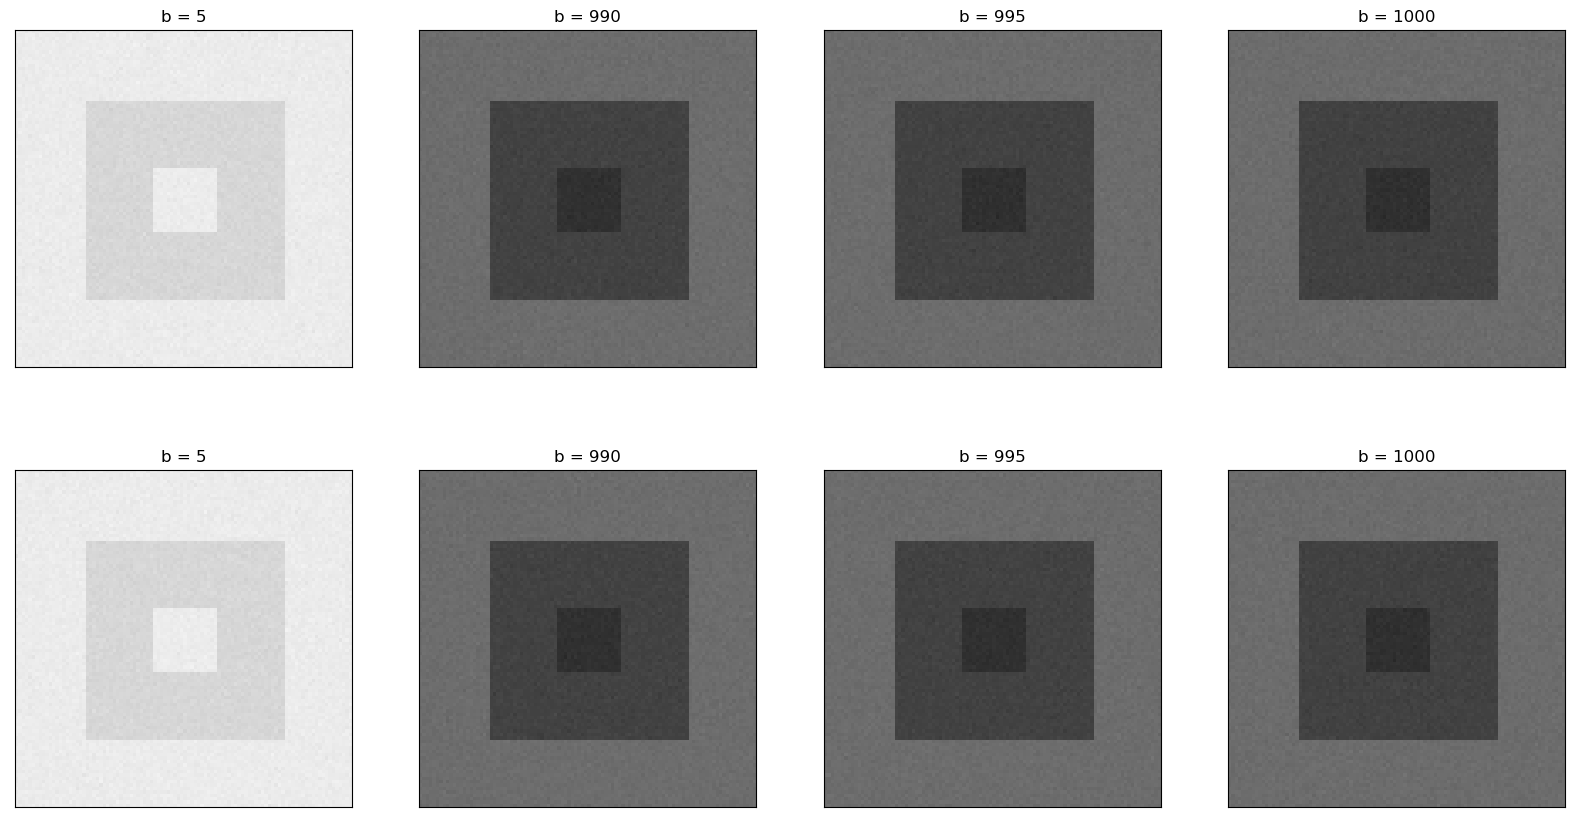

In [39]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
Dp_region0, Dp_region1, Dp_region2 = 0.02, 0.04, 0.06
Dt_region0, Dt_region1, Dt_region2 = 0.0015, 0.0010, 0.0005
Fp_region0, Fp_region1, Fp_region2 = 0.1, 0.2, 0.3
# image size
sx, sy, sb = 100, 100, len(b_values_simulation)
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))
# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*ivim(b_values_simulation, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values_simulation, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values_simulation, Dp_region2, Dt_region2, Fp_region2)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values_simulation[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()


## Inference

Estimate IVIM parameter values for the simulated image.

In [40]:
# normalize signal
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)
dwi_image_long = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    _, Dp, Dt, Fp = net(torch.from_numpy(dwi_image_long.astype(np.float32)))
    
Dp = Dp.numpy()
Dt = Dt.numpy()
Fp = Fp.numpy()

# make sure Dp is the larger value between Dp and Dt
if np.mean(Dp) < np.mean(Dt):
    Dp, Dt = Dt, Dp
    Fp = 1 - Fp

Plot parameter estimates and corresponding ground truths.

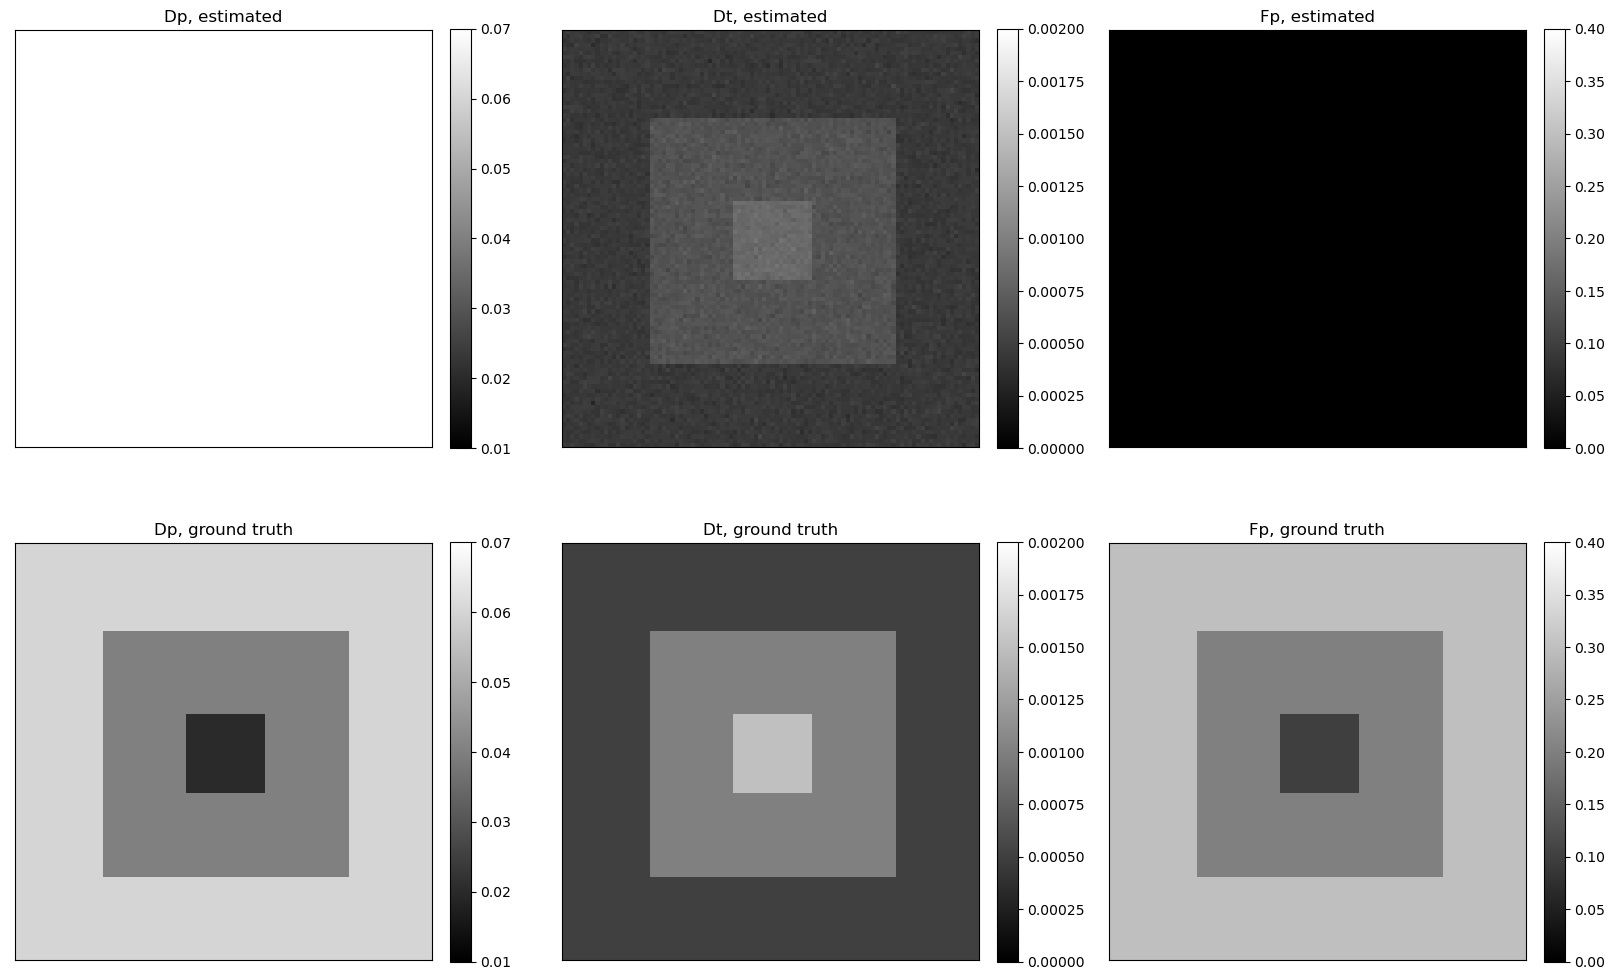

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

Dp_plot = ax[0,0].imshow(np.reshape(Dp, (sx, sy)), cmap='gray', clim=(0.01, 0.07))
ax[0,0].set_title('Dp, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(Dp_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

Dp_t_plot = ax[1,0].imshow(Dp_truth, cmap='gray', clim=(0.01, 0.07))
ax[1,0].set_title('Dp, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(Dp_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

Dt_plot = ax[0,1].imshow(np.reshape(Dt, (sx, sy)), cmap='gray', clim=(0, 0.002))
ax[0,1].set_title('Dt, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(Dt_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

Dt_t_plot = ax[1,1].imshow(Dt_truth, cmap='gray', clim=(0, 0.002))
ax[1,1].set_title('Dt, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(Dt_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)

Fp_plot = ax[0,2].imshow(np.reshape(Fp, (sx, sy)), cmap='gray', clim=(0, 0.4))
ax[0,2].set_title('Fp, estimated')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
fig.colorbar(Fp_plot, ax=ax[0,2],fraction=0.046, pad=0.04)

Fp_t_plot = ax[1,2].imshow(Fp_truth, cmap='gray', clim=(0, 0.4))
ax[1,2].set_title('Fp, ground truth')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
fig.colorbar(Fp_t_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=-0.5)
plt.show()